## 🎥🎬 영화리뷰 텍스트 감성분석하기 

In [1]:
# 필요한 라이브러리 불러오기
import re
import os
import gensim
import tensorflow as tf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from gensim.models import KeyedVectors
from gensim.models import word2vec
from collections import Counter
from konlpy.tag import Mecab
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.layers import GRU, LSTM, Bidirectional
from tensorflow.keras.layers import Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import Constant
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras import optimizers

### 1. 데이터 준비와 확인

In [2]:
# 데이터 읽어오기
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

### 1.1 Train Data 확인

In [3]:
print(train_data.shape)
train_data.head()

(150000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 1.2 Test Data 확인

In [4]:
print(test_data.shape)
test_data.head()

(50000, 3)


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


* 라벨 0이 부정적인 리뷰, 라벨 1이 긍정적인 리뷰
* 150,000개의 train data와 50,000개의 test data

### 2. 데이터로더 구성

* 프로젝트에서 다루는 Naver sentiment movie corpus 데이터에 속한 텍스트는 가공되지 않은 상태
* 데이터 로더를 구성하는 절차는 `imdb.data_loader()` 메소드와 동일하게 동작하도록 설정하는 절차

### 2.1 데이터 정제부터 세트 분리까지

* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전 word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* `X_train`, `y_train`, `X_test`, `y_test`, `word_to_index` 리턴

* 한글 정규표현식 적용 \
https://wikidocs.net/44249

In [5]:
tokenizer = Mecab()
# stopwords: 불용어
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # train data 전처리
    # 중복, 특수문자 제거, 공백을 NULL로 변경, 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data['document'] = train_data['document']
    train_data['document'].replace('', np.nan, inplace=True)
    train_data = train_data.dropna(how = 'any')

    # test data 전처리
    # 중복, 특수문자 제거, 공백을 NULL로 변경, 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data['document'] = test_data['document']
    test_data['document'].replace('', np.nan, inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 단어 사전
    # <BOS>: 문장의 시작지점, <PAD>: 패딩용 단어, <UNK>: 사전에 없는(Unknown) 단어
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}  # {단어:숫자} 딕셔너리 구조
    
    # 텍스트를 단어 사전 인덱스로 변환하는 함수
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

* `load_data()`: data set 전처리 과정 포함. 중복, 특수문자, 결측치를 제거하고 공백을 NULL로 변경하는 동작 수행
* 토큰화 진행 후 `{단어:숫자}` 의 딕셔너리 `word_to_index`가 생성되는 동시에 각 단어에 고유한 정수가 부여된다.
* 전체 훈련 데이터에서 등장 빈도수가 높은 순서대로 부여된다. 
* 높은 정수가 부여된 단어들은 등장 빈도수가 매우 낮다는 것을 의미한다.
* 등장 빈도수가 3회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해본다.
* collections.Counter함수 참조 \
https://www.daleseo.com/python-collections-counter/
* 빨간 경고창 참고 \
https://stackoverflow.com/questions/66603854/futurewarning-the-default-value-of-regex-will-change-from-true-to-false-in-a-fu

In [6]:
threshold = 3
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in word_to_index.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합의 크기 : 10000
등장 빈도가 2번 이하인 희귀 단어의 수: 3
단어 집합에서 희귀 단어의 비율: 0.03
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.000600060006001e-06


* 등장 빈도가 낮은 단어가 많지도 않고, 단어의 비율도 커보이지는 않으나,
* 원래 단어사전의 크기가 그렇게 큰 편도 아닐 뿐더러
* 삭제하지 않더라도 큰 영향은 없어보이므로 그냥 둔다.

In [7]:
print("number of train data: {}, number of test data: {}".format(len(X_train), len(X_test)))

number of train data: 146182, number of test data: 49157


### 2.2 단어사전 만들기

In [8]:
# {숫자:단어}의 index_to_word 단어 사전 생성
index_to_word = {index:word for word, index in word_to_index.items()}

### 2.3 encode, decode

* `get_encoded_sentence` : 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
* `get_encoded_sentences` : 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
* `get_decoded_sentence` : 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
* `get_decoded_sentences` : 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수

In [9]:
# 모든 문장은 <BOS>로 시작하는 것으로 한다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word):                                                   
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [10]:
# encode된 텍스트가 정상적으로 decode되는지 확인
# 첫번째 리뷰 데이터
print(X_train[0])
print(get_decoded_sentence(X_train[0], index_to_word))
print('Label: ', y_train[0])

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
더 빙 . . 진짜 짜증 나 네요 목소리
Label:  0


### 3. 모델 구성을 위한 데이터 분석

### 3.1 데이터셋 내 문장 길이 분포 확인하기

### 3.1.1 문장길이 평균, 최대, 표준편차

In [11]:
# 전체 데이터
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', '%.4f'%np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', '%.4f'%np.std(num_tokens))
print('문장길이 중간 값: {}'.format(np.median(num_tokens)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('문장길이 제 1 사분위: {}'.format(np.percentile(num_tokens, 25)))
print('문장길이 제 3 사분위: {}'.format(np.percentile(num_tokens, 75)))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {:.4f}%가 maxlen 설정값 이내에 포함됩니다!'.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.9694
문장길이 최대 :  116
문장길이 표준편차 :  12.8436
문장길이 중간 값: 12.0
문장길이 제 1 사분위: 7.0
문장길이 제 3 사분위: 19.0
pad_sequences maxlen :  41
전체 문장의 0.9343%가 maxlen 설정값 이내에 포함됩니다!


* 문장의 길이가 평균이 16정도이고, 최댓값이 116으로 확인이 된다.
* 위에서는 `maxlen`= 41 이 된다.
* 평균과 중간값에 차이가 좀 있는 것으로 보아 문장의 길이가 한 쪽으로 치우친 경향이 있을 것으로 예상된다.

### 3.1.2 문장길이 분포

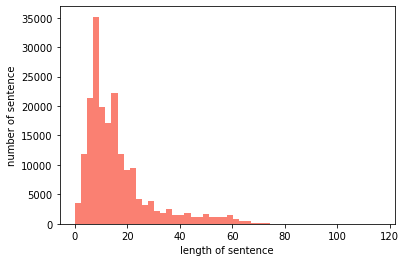

In [12]:
plt.hist(num_tokens, bins=50, color='salmon', label='word')
plt.xlabel('length of sentence')
plt.ylabel('number of sentence')
plt.show()

* 대부분 20이하에 분포되어 있음을 알 수 있다.

{'whiskers': [<matplotlib.lines.Line2D at 0x7efc7756a8e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7efc7756af40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7efc7756a490>],
 'medians': [<matplotlib.lines.Line2D at 0x7efc7757e6a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7efc7757edf0>],
 'means': [<matplotlib.lines.Line2D at 0x7efc7757ea60>]}

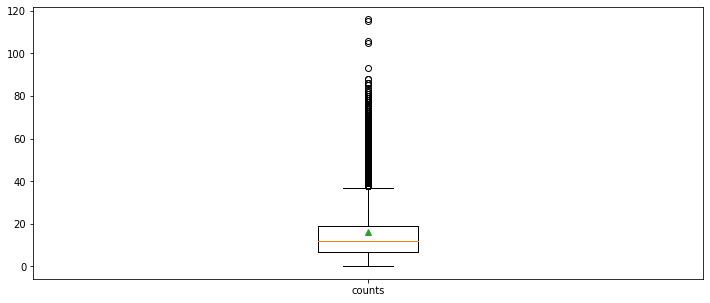

In [13]:
plt.figure(figsize=(12,5))
plt.boxplot(num_tokens, labels=['counts'], showmeans=True)

* 이상치가 좀 많이 확인이 되는 것을 볼 수 있다.
* 문장길이의 분포가 20이하에서 대부분 몰려 있어 위와 같은 현상이 나타난 듯하다.
* 문장길이를 `maxlen`인 41에 맞춰 진행하면 이상치가 어느 정도 삭제되어질 것으로 보여진다.

### 4. 모델 구성을 위한 데이터 가공

* `keras.preprocessing.sequence.pad_sequences`을 활용하여 패딩을 추가
* RNN은 입력데이터의 처리 순서 때문에 pre가 훨씬 유리하며, 10% 이상의 테스트 성능 차이를 보이게 된다.
* 실제로 그러한지 확인해본다.

### 4.1 pre padding

In [14]:
X_train_pre = tf.keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index["<PAD>"],
                                                        padding='pre', maxlen=maxlen)

X_test_pre = tf.keras.preprocessing.sequence.pad_sequences(X_test, value=word_to_index["<PAD>"],
                                                        padding='pre', maxlen=maxlen)

print(X_train_pre.shape)
print(X_test_pre.shape)

(146182, 41)
(49157, 41)


In [15]:
# 첫 번째 리뷰데이터
# 문장 앞에 padding
print(X_train_pre[0])
print(get_decoded_sentence(X_train_pre[0], index_to_word))
print('Label: ', y_train[0])  

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0  32  74 919   4   4
  39 228  20  33 748]
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 아 더 빙 . . 진짜 짜증 나 네요 목소리
Label:  0


### 4.1 post padding

In [16]:
X_train_post = tf.keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index["<PAD>"],
                                                        padding='post', maxlen=maxlen)

X_test_post = tf.keras.preprocessing.sequence.pad_sequences(X_test, value=word_to_index["<PAD>"],
                                                        padding='post', maxlen=maxlen)

print(X_train_post.shape)
print(X_test_post.shape)

(146182, 41)
(49157, 41)


In [17]:
# 첫 번째 리뷰데이터
# 문장 뒤에 padding
print(X_train_post[0])
print(get_decoded_sentence(X_train_post[0], index_to_word))
print('Label: ', y_train[0])  

[ 32  74 919   4   4  39 228  20  33 748   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0]
더 빙 . . 진짜 짜증 나 네요 목소리 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Label:  0


### 5. validation set 및 모델 구성

### 5.1 validation set 준비

* 146182개의 train 세트 중에 43000개를 validation 세트로 사용한다. (약 0.3%)

In [18]:
# validation set 43000건 분리
X_val_pre = X_train_pre[:43000]    # pre 패딩된 train set 분리
X_val_post = X_train_post[:43000]  # post 패딩된 train set 분리
y_val = y_train[:43000]

# validation set을 제외한 나머지
partial_X_train_pre = X_train_pre[43000:]
partial_X_train_post = X_train_post[43000:]
partial_y_train = y_train[43000:]


# validation set 갯수 
print('X_val_pre :', X_val_pre.shape)
print('X_val_post :', X_val_post.shape)
print('y_val :', y_val.shape)

# 나머지 train set 갯수
print('partial_X_train_pre :', partial_X_train_pre.shape)
print('partial_X_train_post :', partial_X_train_post.shape)
print('partial_y_train :', partial_y_train.shape)

X_val_pre : (43000, 41)
X_val_post : (43000, 41)
y_val : (43000,)
partial_X_train_pre : (103182, 41)
partial_X_train_post : (103182, 41)
partial_y_train : (103182,)


### 5.2 모델 구성

* 다양한 RNN모델 사용
  * RNN(Recurrent Neural Network) \
  https://jiho-ml.com/weekly-nlp-18/
  * GRU(Gated Recurrent Unit) : LSTM의 간소버전 \
  https://hyen4110.tistory.com/26
  * LSTM(Long Term Short Memory) \
  https://dgkim5360.tistory.com/entry/understanding-long-short-term-memory-lstm-kr
  * BiLSTM \
  https://ratsgo.github.io/natural%20language%20processing/2017/10/22/manning/ \
  https://keras.io/api/layers/recurrent_layers/bidirectional/
* 1D CNN(Convolutional Neural Network) \
https://gmnam.tistory.com/274

### 5.2.1 RNN(Recurrent Neural Network)

In [19]:
# RNN(Recurrent Neural Network)_pre

vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# 모델은 다 대 일 구조의 RNN 사용
# 마지막 시점에서 두 개의 선택지 중 하나를 예측하는 이진 분류 문제를 수행하는 모델
# 활성화 함수로는 relu, sigmoid 사용
model1 = Sequential()
model1.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(SimpleRNN(32))
model1.add(Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                1568      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 161,601
Trainable params: 161,601
Non-trainable params: 0
_________________________________________________________________


In [20]:
# RNN(Recurrent Neural Network)_post

vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# 모델은 다 대 일 구조의 RNN 사용
# 마지막 시점에서 두 개의 선택지 중 하나를 예측하는 이진 분류 문제를 수행하는 모델
# 활성화 함수로는 relu, sigmoid 사용
model2 = Sequential()
model2.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(SimpleRNN(32))
model2.add(Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                1568      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 161,601
Trainable params: 161,601
Non-trainable params: 0
_________________________________________________________________


### 5.2.2 GRU(Gated Recurrent Unit)

In [21]:
# GRU(Gated Recurrent Unit)_pre

vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# 모델은 다 대 일 구조의 GRU 사용
# 마지막 시점에서 두 개의 선택지 중 하나를 예측하는 이진 분류 문제를 수행하는 모델
# 활성화 함수로는 sigmoid 사용
model3 = Sequential()
model3.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(GRU(128))
model3.add(Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
gru (GRU)                    (None, 128)               56064     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 216,193
Trainable params: 216,193
Non-trainable params: 0
_________________________________________________________________


In [22]:
# GRU(Gated Recurrent Unit)_post

vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# 모델은 다 대 일 구조의 GRU 사용
# 마지막 시점에서 두 개의 선택지 중 하나를 예측하는 이진 분류 문제를 수행하는 모델
# 활성화 함수로는 sigmoid 사용
model4 = Sequential()
model4.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model4.add(GRU(128))
model4.add(Dense(1, activation='sigmoid'))

model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               56064     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 216,193
Trainable params: 216,193
Non-trainable params: 0
_________________________________________________________________


### 5.2.3 LSTM(Long Term Short Memory)

In [23]:
# LSTM(Long Term Short Memory)_pre

vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

#  모델은 다 대 일 구조의 LSTM 사용
# 마지막 시점에서 두 개의 선택지 중 하나를 예측하는 이진 분류 문제를 수행하는 모델
# 활성화 함수로는 relu, softmax 사용
model5 = Sequential()
model5.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model5.add(LSTM(8))  # LSTM state 벡터의 차원수 (변경가능)
model5.add(Dense(8, activation='relu'))
model5.add(Dense(1, activation='softmax'))  

model5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [24]:
# LSTM(Long Term Short Memory)_post

vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

#  모델은 다 대 일 구조의 LSTM 사용
# 마지막 시점에서 두 개의 선택지 중 하나를 예측하는 이진 분류 문제를 수행하는 모델
# 활성화 함수로는 relu, softmax 사용
model6 = Sequential()
model6.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model6.add(LSTM(8))  # LSTM state 벡터의 차원수 (변경가능)
model6.add(Dense(8, activation='relu'))
model6.add(Dense(1, activation='softmax'))  

model6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


### 5.2.4 BiLSTM(양방향 LSTM)

In [25]:
# BiLSTM_pre

vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

model7 = Sequential()
model7.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model7.add(Bidirectional(LSTM(128))) # Bidirectional LSTM을 사용
model7.add(Dense(1, activation='sigmoid'))

model7.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               148480    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 308,737
Trainable params: 308,737
Non-trainable params: 0
_________________________________________________________________


In [26]:
# BiLSTM_post

vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

model8 = Sequential()
model8.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model8.add(Bidirectional(LSTM(128))) # Bidirectional LSTM을 사용
model8.add(Dense(1, activation='sigmoid'))

model8.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               148480    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 308,737
Trainable params: 308,737
Non-trainable params: 0
_________________________________________________________________


### 5.2.5 1-D CNN(Convolution Neural Network)

In [27]:
# 1-D CNN_pre

vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# 커널의 크기는 3이며 해당 커널은 총 16개 사용
#  해당 모델은 마지막 시점에서 두 개의 선택지 중 하나를 예측하는 이진 분류 문제를 수행하는 모델
# 활성화 함수로는 relu, sigmoid 사용
model9 = Sequential()
model9.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model9.add(Conv1D(16, 3, activation='relu'))
model9.add(MaxPooling1D(5))
model9.add(Conv1D(16, 3, activation='relu'))
model9.add(GlobalMaxPooling1D())
model9.add(Dense(8, activation='relu'))
model9.add(Dense(1, activation='sigmoid'))

model9.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [28]:
# 1-D CNN_post

vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# 커널의 크기는 3이며 해당 커널은 총 16개 사용
# 해당 모델은 마지막 시점에서 두 개의 선택지 중 하나를 예측하는 이진 분류 문제를 수행하는 모델
# 활성화 함수로는 relu, sigmoid 사용
model10 = Sequential()
model10.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model10.add(Conv1D(16, 3, activation='relu'))
model10.add(MaxPooling1D(5))
model10.add(Conv1D(16, 3, activation='relu'))
model10.add(GlobalMaxPooling1D())
model10.add(Dense(8, activation='relu'))
model10.add(Dense(1, activation='sigmoid'))

model10.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

### 6. 모델 학습 및  평가

### 6.1 RNN(Recurrent Neural Network)

### 6.1.1 RNN(Recurrent Neural Network)_pre 모델 학습

In [29]:
# RNN(Recurrent Neural Network)_pre
# 검증 데이터 손실이 2회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)
# ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('RNN_pre_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 손실 함수로 크로스 엔트로피 함수 사용
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history_RNN_pre = model1.fit(partial_X_train_pre, partial_y_train, epochs=10, 
                             batch_size=128, validation_data=(X_val_pre, y_val),verbose=1)

Epoch 1/10
807/807 [==============================] - 29s 34ms/step - loss: 0.4322 - acc: 0.7938 - val_loss: 0.3520 - val_acc: 0.8480
Epoch 2/10
807/807 [==============================] - 27s 34ms/step - loss: 0.3277 - acc: 0.8607 - val_loss: 0.3608 - val_acc: 0.8415
Epoch 3/10
807/807 [==============================] - 27s 34ms/step - loss: 0.2828 - acc: 0.8837 - val_loss: 0.3793 - val_acc: 0.8377
Epoch 4/10
807/807 [==============================] - 27s 33ms/step - loss: 0.2301 - acc: 0.9088 - val_loss: 0.4109 - val_acc: 0.8332
Epoch 5/10
807/807 [==============================] - 27s 34ms/step - loss: 0.1849 - acc: 0.9301 - val_loss: 0.4733 - val_acc: 0.8282
Epoch 6/10
807/807 [==============================] - 27s 34ms/step - loss: 0.1512 - acc: 0.9442 - val_loss: 0.5145 - val_acc: 0.8225
Epoch 7/10
807/807 [==============================] - 27s 34ms/step - loss: 0.1261 - acc: 0.9553 - val_loss: 0.5969 - val_acc: 0.8115
Epoch 8/10
807/807 [==============================] - 27s 34ms

### 6.1.2 RNN(Recurrent Neural Network)_pre 모델 평가

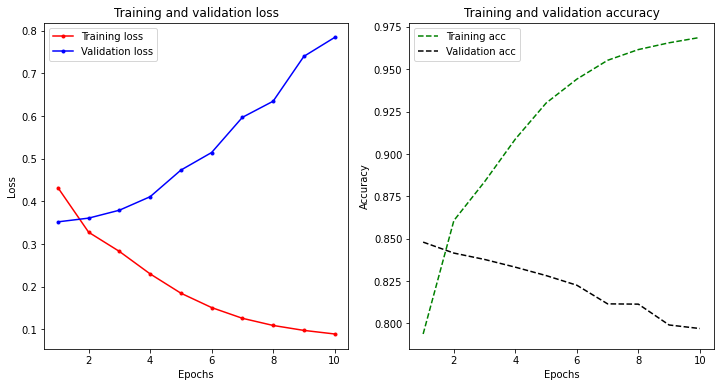

In [30]:
history_RNN_pre_dict = history_RNN_pre.history

acc = history_RNN_pre_dict['acc']
val_acc = history_RNN_pre_dict['val_acc']
loss = history_RNN_pre_dict['loss']
val_loss = history_RNN_pre_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,6))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, marker='.', c='red', label='Training loss')
plt.plot(epochs, val_loss, marker='.', c='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'g--', label='Training acc')
plt.plot(epochs, val_acc, 'k--', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [31]:
# 모델 평가
results = model1.evaluate(X_test_pre, y_test, verbose=2)
print(results)

1537/1537 - 6s - loss: 0.8071 - acc: 0.7928
[0.8070661425590515, 0.7927660346031189]


### 6.1.3 RNN(Recurrent Neural Network)_post 모델 학습

In [32]:
# RNN(Recurrent Neural Network)_post
# 검증 데이터 손실이 2회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)
# ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('RNN_post_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 손실 함수로 크로스 엔트로피 함수 사용
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history_RNN_post = model2.fit(partial_X_train_post, partial_y_train, epochs=10, 
                              batch_size=128, validation_data=(X_val_post, y_val),verbose=1)

Epoch 1/10
807/807 [==============================] - 28s 34ms/step - loss: 0.4734 - acc: 0.7746 - val_loss: 0.4310 - val_acc: 0.8110
Epoch 2/10
807/807 [==============================] - 27s 34ms/step - loss: 0.3715 - acc: 0.8416 - val_loss: 0.3817 - val_acc: 0.8326
Epoch 3/10
807/807 [==============================] - 27s 34ms/step - loss: 0.3280 - acc: 0.8644 - val_loss: 0.3704 - val_acc: 0.8382
Epoch 4/10
807/807 [==============================] - 27s 34ms/step - loss: 0.2948 - acc: 0.8802 - val_loss: 0.3812 - val_acc: 0.8428
Epoch 5/10
807/807 [==============================] - 27s 34ms/step - loss: 0.2689 - acc: 0.8921 - val_loss: 0.3959 - val_acc: 0.8266
Epoch 6/10
807/807 [==============================] - 27s 34ms/step - loss: 0.2447 - acc: 0.9041 - val_loss: 0.4010 - val_acc: 0.8349
Epoch 7/10
807/807 [==============================] - 27s 34ms/step - loss: 0.2255 - acc: 0.9131 - val_loss: 0.4319 - val_acc: 0.8332
Epoch 8/10
807/807 [==============================] - 27s 34ms

### 6.1.4 RNN(Recurrent Neural Network)_post 모델 평가

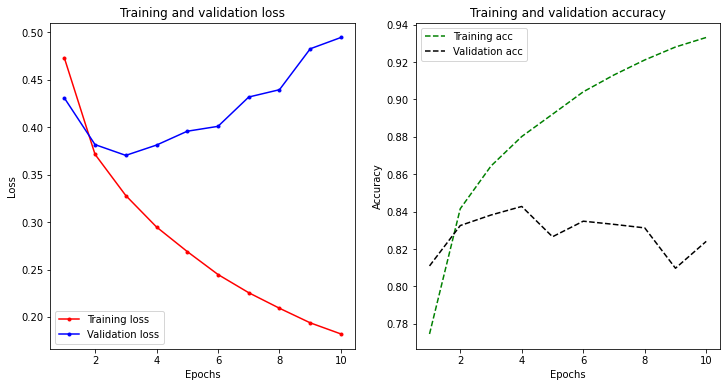

In [33]:
history_RNN_post_dict = history_RNN_post.history

acc = history_RNN_post_dict['acc']
val_acc = history_RNN_post_dict['val_acc']
loss = history_RNN_post_dict['loss']
val_loss = history_RNN_post_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,6))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, marker='.', c='red', label='Training loss')
plt.plot(epochs, val_loss, marker='.', c='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'g--', label='Training acc')
plt.plot(epochs, val_acc, 'k--', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [34]:
# 모델 평가
results = model2.evaluate(X_test_post, y_test, verbose=2)
print(results)

1537/1537 - 6s - loss: 0.5015 - acc: 0.8210
[0.5015251040458679, 0.8210224509239197]


### 6.2 GRU(Gated Recurrent Unit)

### 6.2.1 GRU(Gated Recurrent Unit)_pre 모델 학습

In [35]:
# GRU(Gated Recurrent Unit)_pre
# 검증 데이터 손실이 2회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)
# ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('GRU_pre_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 손실 함수로 크로스 엔트로피 함수 사용
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history_GRU_pre = model3.fit(partial_X_train_pre, partial_y_train, epochs=10, 
                             batch_size=128, validation_data=(X_val_pre, y_val),verbose=1)

Epoch 1/10
807/807 [==============================] - 8s 6ms/step - loss: 0.4079 - acc: 0.8102 - val_loss: 0.3578 - val_acc: 0.8430
Epoch 2/10
807/807 [==============================] - 5s 6ms/step - loss: 0.3266 - acc: 0.8599 - val_loss: 0.3402 - val_acc: 0.8519
Epoch 3/10
807/807 [==============================] - 5s 6ms/step - loss: 0.2955 - acc: 0.8764 - val_loss: 0.3335 - val_acc: 0.8563
Epoch 4/10
807/807 [==============================] - 5s 6ms/step - loss: 0.2678 - acc: 0.8899 - val_loss: 0.3326 - val_acc: 0.8580
Epoch 5/10
807/807 [==============================] - 5s 6ms/step - loss: 0.2429 - acc: 0.9021 - val_loss: 0.3494 - val_acc: 0.8546
Epoch 6/10
807/807 [==============================] - 5s 6ms/step - loss: 0.2202 - acc: 0.9120 - val_loss: 0.3687 - val_acc: 0.8519
Epoch 7/10
807/807 [==============================] - 5s 6ms/step - loss: 0.2010 - acc: 0.9213 - val_loss: 0.3946 - val_acc: 0.8509
Epoch 8/10
807/807 [==============================] - 5s 6ms/step - loss: 0.

### 6.2.2 GRU(Gated Recurrent Unit)_pre 모델 평가

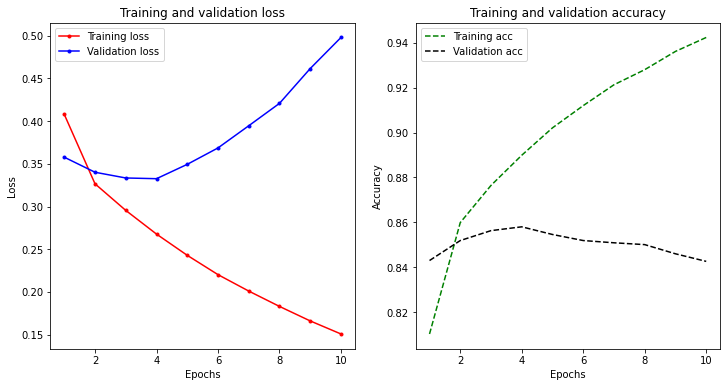

In [36]:
history_GRU_pre_dict = history_GRU_pre.history

acc = history_GRU_pre_dict['acc']
val_acc = history_GRU_pre_dict['val_acc']
loss = history_GRU_pre_dict['loss']
val_loss = history_GRU_pre_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,6))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, marker='.', c='red', label='Training loss')
plt.plot(epochs, val_loss, marker='.', c='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'g--', label='Training acc')
plt.plot(epochs, val_acc, 'k--', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [37]:
# 모델 평가
results = model3.evaluate(X_test_pre, y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.5040 - acc: 0.8392
[0.5040484666824341, 0.8392497301101685]


### 6.2.3 GRU(Gated Recurrent Unit)_post 모델학습

In [38]:
# GRU(Gated Recurrent Unit)_post
# 검증 데이터 손실이 2회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)
# ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('GRU_post_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 손실 함수로 크로스 엔트로피 함수를 사용
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history_GRU_post = model4.fit(partial_X_train_post, partial_y_train, epochs=10, 
                              batch_size=128, validation_data=(X_val_post, y_val),verbose=1)

Epoch 1/10
807/807 [==============================] - 6s 6ms/step - loss: 0.5685 - acc: 0.6508 - val_loss: 0.3655 - val_acc: 0.8408
Epoch 2/10
807/807 [==============================] - 5s 6ms/step - loss: 0.3475 - acc: 0.8513 - val_loss: 0.3390 - val_acc: 0.8531
Epoch 3/10
807/807 [==============================] - 5s 6ms/step - loss: 0.3027 - acc: 0.8738 - val_loss: 0.3262 - val_acc: 0.8580
Epoch 4/10
807/807 [==============================] - 5s 6ms/step - loss: 0.2712 - acc: 0.8883 - val_loss: 0.3352 - val_acc: 0.8580
Epoch 5/10
807/807 [==============================] - 5s 6ms/step - loss: 0.2475 - acc: 0.8990 - val_loss: 0.3472 - val_acc: 0.8585
Epoch 6/10
807/807 [==============================] - 5s 6ms/step - loss: 0.2277 - acc: 0.9081 - val_loss: 0.3535 - val_acc: 0.8532
Epoch 7/10
807/807 [==============================] - 5s 6ms/step - loss: 0.2129 - acc: 0.9140 - val_loss: 0.4057 - val_acc: 0.8503
Epoch 8/10
807/807 [==============================] - 5s 6ms/step - loss: 0.

### 6.2.4 GRU(Gated Recurrent Unit)_post 모델평가

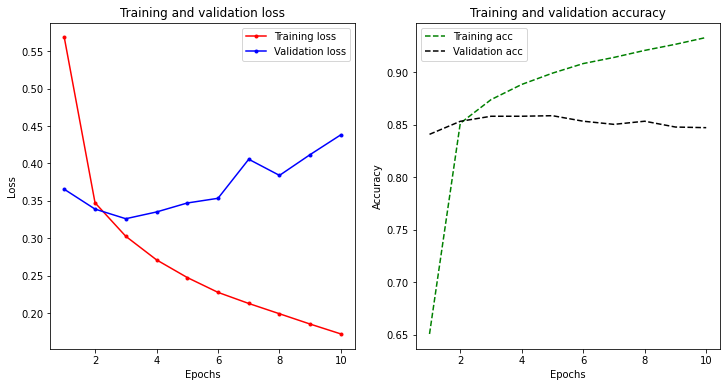

In [39]:
history_GRU_post_dict = history_GRU_post.history

acc = history_GRU_post_dict['acc']
val_acc = history_GRU_post_dict['val_acc']
loss = history_GRU_post_dict['loss']
val_loss = history_GRU_post_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,6))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, marker='.', c='red', label='Training loss')
plt.plot(epochs, val_loss, marker='.', c='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'g--', label='Training acc')
plt.plot(epochs, val_acc, 'k--', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [40]:
# 모델 평가
results = model4.evaluate(X_test_post, y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.4506 - acc: 0.8402
[0.4506499171257019, 0.8401651978492737]


### 6.3 LSTM(Long Term Short Memory)

### 6.3.1 LSTM(Long Term Short Memory)_pre 모델학습

In [41]:
# LSTM(Long Term Short Memory)_pre
# 검증 데이터 손실이 2회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)
# ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('LSTM_pre_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 손실 함수로 크로스 엔트로피 함수 사용
model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history_LSTM_pre = model5.fit(partial_X_train_pre, partial_y_train, epochs=10, 
                              batch_size=128, validation_data=(X_val_pre, y_val),verbose=1)

Epoch 1/10
807/807 [==============================] - 6s 6ms/step - loss: 0.4371 - acc: 0.4978 - val_loss: 0.3526 - val_acc: 0.4994
Epoch 2/10
807/807 [==============================] - 4s 6ms/step - loss: 0.3323 - acc: 0.4978 - val_loss: 0.3471 - val_acc: 0.4994
Epoch 3/10
807/807 [==============================] - 4s 6ms/step - loss: 0.3074 - acc: 0.4978 - val_loss: 0.3444 - val_acc: 0.4994
Epoch 4/10
807/807 [==============================] - 4s 6ms/step - loss: 0.2874 - acc: 0.4978 - val_loss: 0.3481 - val_acc: 0.4994
Epoch 5/10
807/807 [==============================] - 5s 6ms/step - loss: 0.2672 - acc: 0.4978 - val_loss: 0.3573 - val_acc: 0.4994
Epoch 6/10
807/807 [==============================] - 4s 6ms/step - loss: 0.2485 - acc: 0.4978 - val_loss: 0.3721 - val_acc: 0.4994
Epoch 7/10
807/807 [==============================] - 5s 6ms/step - loss: 0.2290 - acc: 0.4978 - val_loss: 0.3601 - val_acc: 0.4994
Epoch 8/10
807/807 [==============================] - 4s 6ms/step - loss: 0.

### 6.3.2 LSTM(Long Term Short Memory)_pre 모델평가

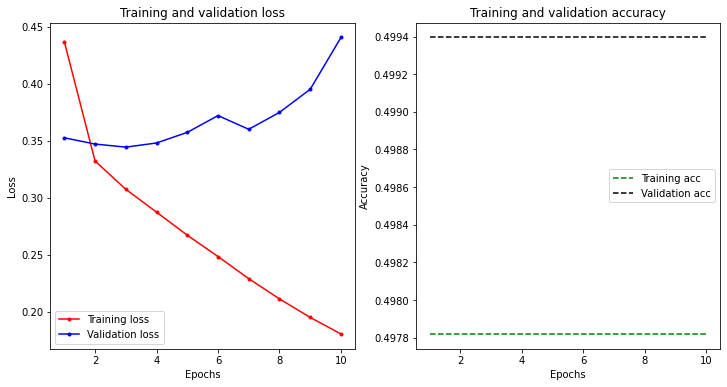

In [42]:
history_LSTM_pre_dict = history_LSTM_pre.history

acc = history_LSTM_pre_dict['acc']
val_acc = history_LSTM_pre_dict['val_acc']
loss = history_LSTM_pre_dict['loss']
val_loss = history_LSTM_pre_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,6))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, marker='.', c='red', label='Training loss')
plt.plot(epochs, val_loss, marker='.', c='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'g--', label='Training acc')
plt.plot(epochs, val_acc, 'k--', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [43]:
# 모델 평가
results = model5.evaluate(X_test_pre, y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.4533 - acc: 0.5027
[0.4533293545246124, 0.5026954412460327]


### 6.3.3 LSTM(Long Term Short Memory)_post 모델학습

In [44]:
# LSTM(Long Term Short Memory)_post
# 검증 데이터 손실이 2회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)
# ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('LSTM_post_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 손실 함수로 크로스 엔트로피 함수 사용
model6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history_LSTM_post = model6.fit(partial_X_train_post, partial_y_train, epochs=10, 
                               batch_size=128, validation_data=(X_val_post, y_val),verbose=1)

Epoch 1/10
807/807 [==============================] - 6s 6ms/step - loss: 0.4761 - acc: 0.4978 - val_loss: 0.3532 - val_acc: 0.4994
Epoch 2/10
807/807 [==============================] - 4s 6ms/step - loss: 0.3338 - acc: 0.4978 - val_loss: 0.3434 - val_acc: 0.4994
Epoch 3/10
807/807 [==============================] - 5s 6ms/step - loss: 0.3105 - acc: 0.4978 - val_loss: 0.3597 - val_acc: 0.4994
Epoch 4/10
807/807 [==============================] - 5s 6ms/step - loss: 0.2945 - acc: 0.4978 - val_loss: 0.3512 - val_acc: 0.4994
Epoch 5/10
807/807 [==============================] - 5s 6ms/step - loss: 0.2795 - acc: 0.4978 - val_loss: 0.3670 - val_acc: 0.4994
Epoch 6/10
807/807 [==============================] - 5s 6ms/step - loss: 0.2653 - acc: 0.4978 - val_loss: 0.3772 - val_acc: 0.4994
Epoch 7/10
807/807 [==============================] - 5s 6ms/step - loss: 0.2513 - acc: 0.4978 - val_loss: 0.3888 - val_acc: 0.4994
Epoch 8/10
807/807 [==============================] - 5s 6ms/step - loss: 0.

### 6.3.4 LSTM(Long Term Short Memory)_post 모델평가

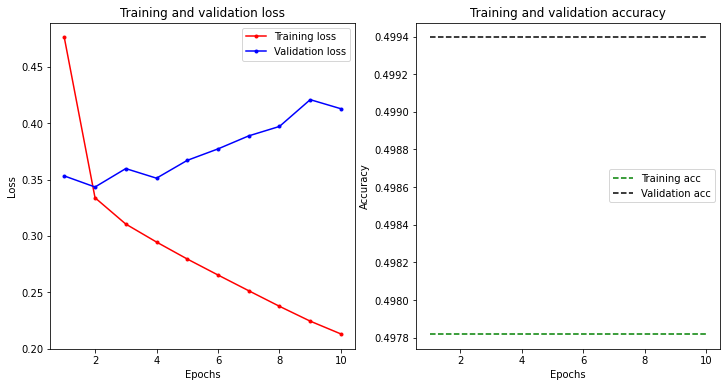

In [45]:
history_LSTM_post_dict = history_LSTM_post.history

acc = history_LSTM_post_dict['acc']
val_acc = history_LSTM_post_dict['val_acc']
loss = history_LSTM_post_dict['loss']
val_loss = history_LSTM_post_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,6))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, marker='.', c='red', label='Training loss')
plt.plot(epochs, val_loss, marker='.', c='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'g--', label='Training acc')
plt.plot(epochs, val_acc, 'k--', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [46]:
# 모델 평가
results = model6.evaluate(X_test_post, y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.4203 - acc: 0.5027
[0.42034462094306946, 0.5026954412460327]


### 6.4 BiLSTM

### 6.3.1 BiLSTM_pre 모델학습

In [47]:
# BiLSTM_pre
# 검증 데이터 손실이 2회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)
# ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('BiLSTM_pre_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 손실 함수로 크로스 엔트로피 함수 사용
model7.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history_BiLSTM_pre = model7.fit(partial_X_train_pre, partial_y_train, epochs=10, 
                                batch_size=128, validation_data=(X_val_pre, y_val),verbose=1)

Epoch 1/10
807/807 [==============================] - 10s 10ms/step - loss: 0.4124 - acc: 0.8086 - val_loss: 0.3485 - val_acc: 0.8483
Epoch 2/10
807/807 [==============================] - 7s 8ms/step - loss: 0.3326 - acc: 0.8585 - val_loss: 0.3476 - val_acc: 0.8501
Epoch 3/10
807/807 [==============================] - 7s 9ms/step - loss: 0.3102 - acc: 0.8695 - val_loss: 0.3412 - val_acc: 0.8500
Epoch 4/10
807/807 [==============================] - 7s 9ms/step - loss: 0.2834 - acc: 0.8821 - val_loss: 0.3390 - val_acc: 0.8554
Epoch 5/10
807/807 [==============================] - 7s 9ms/step - loss: 0.2568 - acc: 0.8943 - val_loss: 0.3552 - val_acc: 0.8554
Epoch 6/10
807/807 [==============================] - 7s 9ms/step - loss: 0.2327 - acc: 0.9053 - val_loss: 0.3529 - val_acc: 0.8557
Epoch 7/10
807/807 [==============================] - 7s 9ms/step - loss: 0.2114 - acc: 0.9152 - val_loss: 0.3958 - val_acc: 0.8509
Epoch 8/10
807/807 [==============================] - 7s 9ms/step - loss: 

### 6.3.2 BiLSTM_pre 모델평가

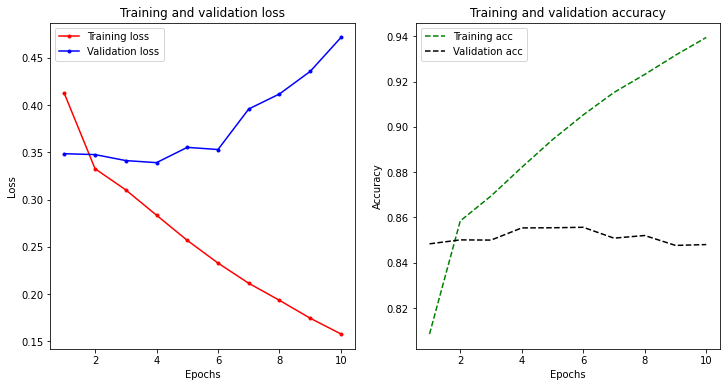

In [48]:
history_BiLSTM_pre_dict = history_BiLSTM_pre.history

acc = history_BiLSTM_pre_dict['acc']
val_acc = history_BiLSTM_pre_dict['val_acc']
loss = history_BiLSTM_pre_dict['loss']
val_loss = history_BiLSTM_pre_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,6))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, marker='.', c='red', label='Training loss')
plt.plot(epochs, val_loss, marker='.', c='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'g--', label='Training acc')
plt.plot(epochs, val_acc, 'k--', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [49]:
# 모델 평가
results = model7.evaluate(X_test_pre, y_test, verbose=2)
print(results)

1537/1537 - 4s - loss: 0.4801 - acc: 0.8435
[0.4800625741481781, 0.843460738658905]


### 6.3.3 BiLSTM_post 모델학습

In [50]:
# BiLSTM_post
# 검증 데이터 손실이 2회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)
# ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('BiLSTM_post_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 손실 함수로 크로스 엔트로피 함수 사용
model8.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history_BiLSTM_post = model8.fit(partial_X_train_post, partial_y_train, epochs=10, 
                                 batch_size=128, validation_data=(X_val_post, y_val),verbose=1)

Epoch 1/10
807/807 [==============================] - 10s 9ms/step - loss: 0.4136 - acc: 0.8075 - val_loss: 0.3625 - val_acc: 0.8467
Epoch 2/10
807/807 [==============================] - 7s 9ms/step - loss: 0.3344 - acc: 0.8575 - val_loss: 0.3661 - val_acc: 0.8396
Epoch 3/10
807/807 [==============================] - 7s 9ms/step - loss: 0.3043 - acc: 0.8737 - val_loss: 0.3353 - val_acc: 0.8538
Epoch 4/10
807/807 [==============================] - 7s 9ms/step - loss: 0.2756 - acc: 0.8870 - val_loss: 0.3445 - val_acc: 0.8549
Epoch 5/10
807/807 [==============================] - 7s 9ms/step - loss: 0.2482 - acc: 0.8998 - val_loss: 0.3556 - val_acc: 0.8538
Epoch 6/10
807/807 [==============================] - 7s 9ms/step - loss: 0.2248 - acc: 0.9104 - val_loss: 0.3693 - val_acc: 0.8524
Epoch 7/10
807/807 [==============================] - 7s 9ms/step - loss: 0.2057 - acc: 0.9190 - val_loss: 0.3914 - val_acc: 0.8508
Epoch 8/10
807/807 [==============================] - 7s 9ms/step - loss: 0

### 6.3.4 BiLSTM_post 모델평가

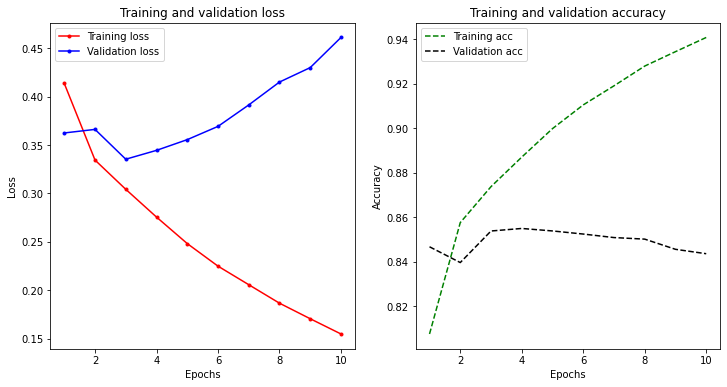

In [51]:
history_BiLSTM_post_dict = history_BiLSTM_post.history

acc = history_BiLSTM_post_dict['acc']
val_acc = history_BiLSTM_post_dict['val_acc']
loss = history_BiLSTM_post_dict['loss']
val_loss = history_BiLSTM_post_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,6))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, marker='.', c='red', label='Training loss')
plt.plot(epochs, val_loss, marker='.', c='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'g--', label='Training acc')
plt.plot(epochs, val_acc, 'k--', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [52]:
# 모델 평가
results = model8.evaluate(X_test_post, y_test, verbose=2)
print(results)

1537/1537 - 4s - loss: 0.4728 - acc: 0.8393
[0.4728246033191681, 0.8393311500549316]


### 6.4 1-D CNN

### 6.4.1 1-D CNN_pre 모델학습

In [53]:
# 1-D CNN_pre
# 검증 데이터 손실이 2회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)
# ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('1DCNN_pre_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 손실 함수로 크로스 엔트로피 함수 사용
model9.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history_1DCNN_pre = model9.fit(partial_X_train_pre, partial_y_train, epochs=10, 
                               batch_size=128, validation_data=(X_val_pre, y_val),verbose=1)

Epoch 1/10
807/807 [==============================] - 5s 5ms/step - loss: 0.5301 - acc: 0.7113 - val_loss: 0.4584 - val_acc: 0.7667
Epoch 2/10
807/807 [==============================] - 4s 5ms/step - loss: 0.4252 - acc: 0.7914 - val_loss: 0.4606 - val_acc: 0.7661
Epoch 3/10
807/807 [==============================] - 4s 5ms/step - loss: 0.3858 - acc: 0.8132 - val_loss: 0.4673 - val_acc: 0.7683
Epoch 4/10
807/807 [==============================] - 4s 5ms/step - loss: 0.3482 - acc: 0.8332 - val_loss: 0.4849 - val_acc: 0.7667
Epoch 5/10
807/807 [==============================] - 4s 5ms/step - loss: 0.3111 - acc: 0.8529 - val_loss: 0.5215 - val_acc: 0.7608
Epoch 6/10
807/807 [==============================] - 4s 5ms/step - loss: 0.2782 - acc: 0.8693 - val_loss: 0.5593 - val_acc: 0.7578
Epoch 7/10
807/807 [==============================] - 4s 5ms/step - loss: 0.2485 - acc: 0.8823 - val_loss: 0.6193 - val_acc: 0.7525
Epoch 8/10
807/807 [==============================] - 4s 5ms/step - loss: 0.

### 6.4.2 1-D CNN_pre 모델평가

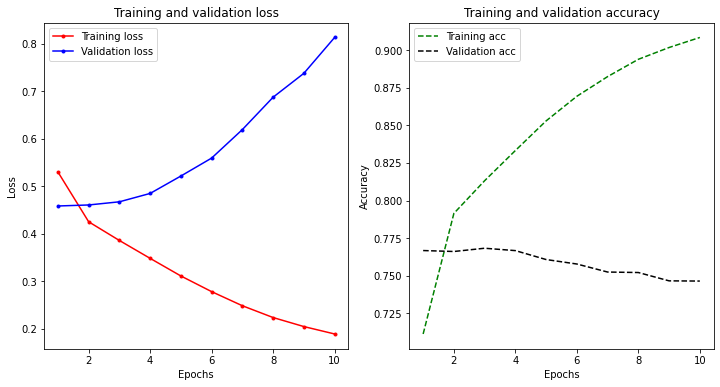

In [54]:
history_1DCNN_pre_dict = history_1DCNN_pre.history

acc = history_1DCNN_pre_dict['acc']
val_acc = history_1DCNN_pre_dict['val_acc']
loss = history_1DCNN_pre_dict['loss']
val_loss = history_1DCNN_pre_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,6))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, marker='.', c='red', label='Training loss')
plt.plot(epochs, val_loss, marker='.', c='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'g--', label='Training acc')
plt.plot(epochs, val_acc, 'k--', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [55]:
# 모델 평가
results = model9.evaluate(X_test_pre, y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.8221 - acc: 0.7440
[0.8220548629760742, 0.7439835667610168]


### 6.4.3 1-D CNN_post 모델학습

In [56]:
# 1-D CNN_post
# 검증 데이터 손실이 2회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)
# ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('1DCNN_post_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 손실 함수로 크로스 엔트로피 함수 사용
model10.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history_1DCNN_post = model10.fit(partial_X_train_post, partial_y_train, epochs=10, 
                                 batch_size=128, validation_data=(X_val_post, y_val),verbose=1)

Epoch 1/10
807/807 [==============================] - 4s 5ms/step - loss: 0.4413 - acc: 0.7880 - val_loss: 0.3523 - val_acc: 0.8458
Epoch 2/10
807/807 [==============================] - 4s 5ms/step - loss: 0.3172 - acc: 0.8664 - val_loss: 0.3425 - val_acc: 0.8522
Epoch 3/10
807/807 [==============================] - 4s 5ms/step - loss: 0.2761 - acc: 0.8863 - val_loss: 0.3476 - val_acc: 0.8505
Epoch 4/10
807/807 [==============================] - 4s 5ms/step - loss: 0.2410 - acc: 0.9048 - val_loss: 0.3681 - val_acc: 0.8446
Epoch 5/10
807/807 [==============================] - 4s 5ms/step - loss: 0.2073 - acc: 0.9209 - val_loss: 0.3902 - val_acc: 0.8440
Epoch 6/10
807/807 [==============================] - 4s 5ms/step - loss: 0.1759 - acc: 0.9363 - val_loss: 0.4151 - val_acc: 0.8398
Epoch 7/10
807/807 [==============================] - 4s 5ms/step - loss: 0.1475 - acc: 0.9480 - val_loss: 0.4675 - val_acc: 0.8372
Epoch 8/10
807/807 [==============================] - 4s 5ms/step - loss: 0.

### 6.4.4 1-D CNN_post 모델평가

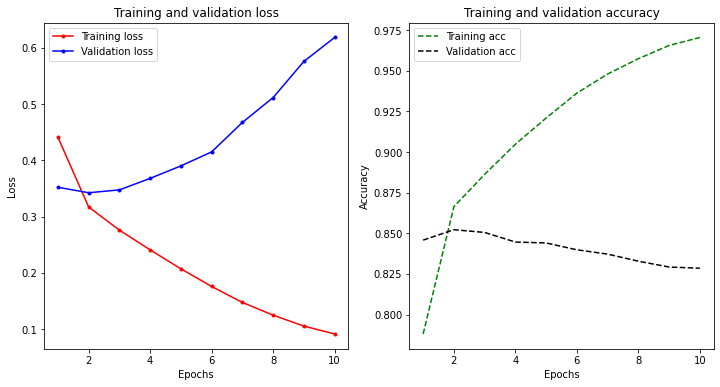

In [57]:
history_1DCNN_post_dict = history_1DCNN_post.history

acc = history_1DCNN_post_dict['acc']
val_acc = history_1DCNN_post_dict['val_acc']
loss = history_1DCNN_post_dict['loss']
val_loss = history_1DCNN_post_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,6))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, marker='.', c='red', label='Training loss')
plt.plot(epochs, val_loss, marker='.', c='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'g--', label='Training acc')
plt.plot(epochs, val_acc, 'k--', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [58]:
# 모델 평가
results = model10.evaluate(X_test_post, y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.6249 - acc: 0.8236
[0.6248660087585449, 0.8236466646194458]


### 6.5 결과정리

|Model|Loss|Accuracy|
|:---:|:---:|:---:|
|RNN(pre)|0.8071|0.7928|
|RNN(post)|0.5015|0.8210|
|GRU(pre)|0.5040|0.8392|
|GRU(post)|0.4506|0.8402|
|LSTM(pre)|0.4533|0.5027|
|LSTM(post)|0.4203|0.5027|
|BiLSTM(pre)|0.4801|0.8435|
|BiLSTM(post)|0.4728|0.8393|
|1-D CNN(pre)|0.8221|0.7440|
|1-D CNN(post)|0.6249|0.8236|

* pre와 post를 비교했을 때, post의 정확도가 오히려 더 높게 나오는 경향이 있었다.
* RNN의 경우 모델 자체가 그렇게 복잡한 모델이 아니여서 큰 영향이 없었던게 아닐까 추정해본다.
* 다른 모델들의 경우 차이 확인되지만 유의미한 차이라고 볼 수는 없을 것으로 판단된다.
* BiLSTM의 경우 pre에서 정확도가 좀 더 높게 확인되었다.
* 1-D CNN은 post에서 정확도가 더 높게 확인되었다. (왤까?)

### 7. 학습된 Embedding 레이어 분석

* 각 모델(pre)별로 확인해본다. 
* 1-D CNN 모델은 post로 확인해본다.

### 7.1 RNN(Recurrent Neural Network)

In [59]:
embedding_layer = model1.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [60]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [61]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("사랑")

[('슬퍼요', 0.9107797145843506),
 ('이영애', 0.9085221290588379),
 ('이제서야', 0.9017857909202576),
 ('탄탄', 0.8974224328994751),
 ('흠잡', 0.8959842920303345),
 ('훌쩍', 0.8940876126289368),
 ('눈물나', 0.8932272791862488),
 ('심장', 0.8890641927719116),
 ('비범', 0.8889443874359131),
 ('울컥', 0.8847728371620178)]

### 7.2 GRU(Gated Recurrent Unit)

In [62]:
embedding_layer = model3.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [63]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model3.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [64]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("사랑")

[('느낀', 0.9651418328285217),
 ('소위', 0.9531208276748657),
 ('순수', 0.9523293375968933),
 ('다섯', 0.9498942494392395),
 ('푹', 0.9436818957328796),
 ('달랐', 0.9425501227378845),
 ('사악', 0.9422340989112854),
 ('감사', 0.94188392162323),
 ('꼬박꼬박', 0.9415031671524048),
 ('설레였', 0.9403830766677856)]

### 7.3 LSTM(Long Term Short Memory)

In [65]:
embedding_layer = model5.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [66]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model5.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [67]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("사랑")

[('데요', 0.9670685529708862),
 ('잘생긴', 0.9599155187606812),
 ('웰', 0.957840085029602),
 ('굵', 0.9573618173599243),
 ('갈증', 0.9544306993484497),
 ('깨달음', 0.9519877433776855),
 ('좋아해서', 0.9480651617050171),
 ('퍼센트', 0.9467475414276123),
 ('계시', 0.9456287622451782),
 ('밉', 0.9443857669830322)]

### 7.4 BiLSTM

In [68]:
embedding_layer = model7.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [69]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model7.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [70]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("사랑")

[('느낀', 0.9663518667221069),
 ('으로써', 0.9629613161087036),
 ('반해', 0.9598175883293152),
 ('귀여운', 0.9597281217575073),
 ('강추', 0.9582736492156982),
 ('이영애', 0.955153226852417),
 ('만능', 0.9543163776397705),
 ('여운', 0.9524645805358887),
 ('망설이', 0.9519038200378418),
 ('소주', 0.9510482549667358)]

### 7.5 1-D CNN

In [71]:
embedding_layer = model10.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [72]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model10.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [73]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("사랑")

[('멋졌', 0.9075969457626343),
 ('고급', 0.8588581085205078),
 ('붉', 0.8527008295059204),
 ('직업', 0.8493726849555969),
 ('자존심', 0.8429847955703735),
 ('따뜻', 0.8395630717277527),
 ('밤', 0.8392130136489868),
 ('소화', 0.8342572450637817),
 ('패배', 0.8272861838340759),
 ('스마트폰', 0.8238996267318726)]

* 전반적으로 `사랑`과 관련없는 단어들이 출력된다.

### 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선

### 8.1 한국어 Word2Vec 임베딩 확인

In [74]:
# gensim 패키지 버전 알아보기

import gensim
gensim.__version__

'3.8.3'

In [75]:
# gensim 패키지 버전 down grade
!pip install --upgrade gensim==3.8.3

In [76]:
# 한국어 Word2Vec 파일 불러와 ko_model에 저장하기

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
ko_model = gensim.models.Word2Vec.load(word2vec_path)

In [77]:
# 유사한 단어와 그 유사도 확인
ko_model.wv.most_similar("사랑")

[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

* 역시 거인! 사랑이랑 비슷한 단어들을 출력한다.

### 8.2 각 모델 별 성능 개선 확인

* 이제 한국어 Word2Vec을 사용해서 이전의 모델을 다시 학습시키고 평가한다.

In [78]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 사전학습된 임베딩 레이어의 차원 수 그대로 따라가는 것이 좋다
embedding_matrix = np.random.rand(vocab_size, word_vector_dim) 

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_model:
        embedding_matrix[i] = ko_model[index_to_word[i]]

/tmp/ipykernel_1012/3143846063.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in ko_model:
/tmp/ipykernel_1012/3143846063.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = ko_model[index_to_word[i]]


In [79]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

### 8.2.1 RNN(Recurrent Neural Network)

In [80]:
model_rnn = Sequential()
model_rnn.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(SimpleRNN(32))
model_rnn.add(Dense(1, activation='sigmoid'))

model_rnn.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 200)         2000000   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                7456      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 2,007,489
Trainable params: 2,007,489
Non-trainable params: 0
_________________________________________________________________


In [81]:
model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

history_rnn = model_rnn.fit(partial_X_train_pre, partial_y_train, epochs=10, 
                            batch_size=128, validation_data=(X_val_pre, y_val), callbacks=[early_stopping], verbose=1)

Epoch 1/10
807/807 [==============================] - 29s 35ms/step - loss: 0.4031 - acc: 0.8165 - val_loss: 0.3466 - val_acc: 0.8499
Epoch 2/10
807/807 [==============================] - 28s 35ms/step - loss: 0.2985 - acc: 0.8753 - val_loss: 0.3571 - val_acc: 0.8481
Epoch 3/10
807/807 [==============================] - 28s 35ms/step - loss: 0.2210 - acc: 0.9136 - val_loss: 0.4038 - val_acc: 0.8378
Epoch 4/10
807/807 [==============================] - 29s 35ms/step - loss: 0.1577 - acc: 0.9413 - val_loss: 0.4664 - val_acc: 0.8231
Epoch 5/10
807/807 [==============================] - 28s 35ms/step - loss: 0.1173 - acc: 0.9580 - val_loss: 0.5320 - val_acc: 0.8254
Epoch 00005: early stopping


In [82]:
# 모델 평가
results = model_rnn.evaluate(X_test_pre, y_test, verbose=2)
print(results)

1537/1537 - 7s - loss: 0.5486 - acc: 0.8209
[0.548614501953125, 0.8208800554275513]


### 8.2.2 GRU(Gated Recurrent Unit)

In [83]:
model_gru = Sequential()
model_gru.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gru.add(GRU(128))
model_gru.add(Dense(1, activation='sigmoid'))

model_gru.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 200)         2000000   
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               126720    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 129       
Total params: 2,126,849
Trainable params: 2,126,849
Non-trainable params: 0
_________________________________________________________________


In [84]:
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

history_gru = model_gru.fit(partial_X_train_pre, partial_y_train, epochs=10, 
                            batch_size=128, validation_data=(X_val_pre, y_val), callbacks=[early_stopping], verbose=1)

Epoch 1/10
807/807 [==============================] - 7s 7ms/step - loss: 0.3830 - acc: 0.8261 - val_loss: 0.3280 - val_acc: 0.8563
Epoch 2/10
807/807 [==============================] - 5s 7ms/step - loss: 0.2912 - acc: 0.8771 - val_loss: 0.3181 - val_acc: 0.8620
Epoch 3/10
807/807 [==============================] - 5s 7ms/step - loss: 0.2482 - acc: 0.8974 - val_loss: 0.3280 - val_acc: 0.8589
Epoch 4/10
807/807 [==============================] - 5s 7ms/step - loss: 0.2104 - acc: 0.9144 - val_loss: 0.3481 - val_acc: 0.8577
Epoch 5/10
807/807 [==============================] - 5s 7ms/step - loss: 0.1747 - acc: 0.9307 - val_loss: 0.3916 - val_acc: 0.8520
Epoch 6/10
807/807 [==============================] - 5s 7ms/step - loss: 0.1428 - acc: 0.9447 - val_loss: 0.4386 - val_acc: 0.8501
Epoch 00006: early stopping


In [85]:
# 모델 평가
results = model_gru.evaluate(X_test_pre, y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.4422 - acc: 0.8463
[0.442204087972641, 0.8462680578231812]


### 8.2.3 LSTM(Long Term Short Memory)

In [86]:
# 모델 구성(LMST 사용)

model_lstm = Sequential()
model_lstm.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(LSTM(8))  # LSTM state 벡터의 차원수 (변경가능)
model_lstm.add(Dense(8, activation='relu'))
model_lstm.add(Dense(1, activation='softmax'))  

model_lstm.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 200)         2000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [87]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
              
history = model_lstm.fit(partial_X_train_pre, partial_y_train, epochs=10, 
                         batch_size=128, validation_data=(X_val_pre, y_val), callbacks=[early_stopping], verbose=1)

Epoch 1/10
807/807 [==============================] - 6s 6ms/step - loss: 0.3955 - acc: 0.4978 - val_loss: 0.3350 - val_acc: 0.4994
Epoch 2/10
807/807 [==============================] - 5s 6ms/step - loss: 0.3005 - acc: 0.4978 - val_loss: 0.3301 - val_acc: 0.4994
Epoch 3/10
807/807 [==============================] - 5s 6ms/step - loss: 0.2597 - acc: 0.4978 - val_loss: 0.3449 - val_acc: 0.4994
Epoch 4/10
807/807 [==============================] - 5s 6ms/step - loss: 0.2253 - acc: 0.4978 - val_loss: 0.3676 - val_acc: 0.4994
Epoch 5/10
807/807 [==============================] - 5s 6ms/step - loss: 0.1951 - acc: 0.4978 - val_loss: 0.3994 - val_acc: 0.4994
Epoch 6/10
807/807 [==============================] - 5s 6ms/step - loss: 0.1686 - acc: 0.4978 - val_loss: 0.4213 - val_acc: 0.4994
Epoch 00006: early stopping


In [88]:
# 모델 평가
results = model_lstm.evaluate(X_test_pre, y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.4302 - acc: 0.5027
[0.4302070736885071, 0.5026954412460327]


### 8.2.4 BiLSTM

In [89]:
model_bilstm = Sequential()
model_bilstm.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_bilstm.add(Bidirectional(LSTM(128))) # Bidirectional LSTM을 사용
model_bilstm.add(Dense(1, activation='sigmoid'))

model_bilstm.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 200)         2000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               336896    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 257       
Total params: 2,337,153
Trainable params: 2,337,153
Non-trainable params: 0
_________________________________________________________________


In [90]:
model_bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
              
history = model_bilstm.fit(partial_X_train_pre, partial_y_train, epochs=10, 
                           batch_size=128, validation_data=(X_val_pre, y_val), callbacks=[early_stopping], verbose=1)

Epoch 1/10
807/807 [==============================] - 12s 12ms/step - loss: 0.3866 - acc: 0.8244 - val_loss: 0.3325 - val_acc: 0.8538
Epoch 2/10
807/807 [==============================] - 9s 11ms/step - loss: 0.2939 - acc: 0.8753 - val_loss: 0.3144 - val_acc: 0.8660
Epoch 3/10
807/807 [==============================] - 9s 11ms/step - loss: 0.2483 - acc: 0.8970 - val_loss: 0.3217 - val_acc: 0.8621
Epoch 4/10
807/807 [==============================] - 9s 11ms/step - loss: 0.2089 - acc: 0.9151 - val_loss: 0.3519 - val_acc: 0.8587
Epoch 5/10
807/807 [==============================] - 9s 11ms/step - loss: 0.1734 - acc: 0.9309 - val_loss: 0.4195 - val_acc: 0.8564
Epoch 6/10
807/807 [==============================] - 9s 11ms/step - loss: 0.1439 - acc: 0.9431 - val_loss: 0.4563 - val_acc: 0.8543
Epoch 00006: early stopping


In [91]:
# 모델 평가
results = model_bilstm.evaluate(X_test_pre, y_test, verbose=2)
print(results)

1537/1537 - 5s - loss: 0.4578 - acc: 0.8517
[0.45782315731048584, 0.8517199754714966]


### 8.2.5 1-D CNN

In [92]:
model_cnn = Sequential()
model_cnn.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(Conv1D(16, 3, activation='relu'))
model_cnn.add(MaxPooling1D(5))
model_cnn.add(Conv1D(16, 3, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(8, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))

model_cnn.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 200)         2000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 16)          9616      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_20 (Dense)             (None, 1)               

In [93]:
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
              
history = model_cnn.fit(partial_X_train_pre, partial_y_train, epochs=10, 
                        batch_size=128, validation_data=(X_val_pre, y_val), callbacks=[early_stopping], verbose=1)

Epoch 1/10
807/807 [==============================] - 5s 5ms/step - loss: 0.4972 - acc: 0.7417 - val_loss: 0.4502 - val_acc: 0.7721
Epoch 2/10
807/807 [==============================] - 4s 5ms/step - loss: 0.3928 - acc: 0.8092 - val_loss: 0.4509 - val_acc: 0.7734
Epoch 3/10
807/807 [==============================] - 4s 5ms/step - loss: 0.3174 - acc: 0.8492 - val_loss: 0.4900 - val_acc: 0.7667
Epoch 4/10
807/807 [==============================] - 4s 5ms/step - loss: 0.2521 - acc: 0.8801 - val_loss: 0.5498 - val_acc: 0.7608
Epoch 5/10
807/807 [==============================] - 4s 5ms/step - loss: 0.2041 - acc: 0.9003 - val_loss: 0.6385 - val_acc: 0.7562
Epoch 00005: early stopping


In [94]:
# 모델 평가
results = model_cnn.evaluate(X_test_pre, y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.6509 - acc: 0.7529
[0.6508544683456421, 0.752934455871582]


### 8.3 결과 정리

|Model|Loss|Accuracy|개선된 Loss|개선된 Accuracy|
|:---:|:---:|:---:|:---:|:---:|
|RNN(pre)|0.8071|0.7928|0.5486|0.8209|
|RNN(post)|0.5015|0.8210|-|-|
|GRU(pre)|0.5040|0.8392|0.4422|0.8463|
|GRU(post)|0.4506|0.8402|-|-|
|LSTM(pre)|0.4533|0.5027|0.4302|0.5027|
|LSTM(post)|0.4203|0.5027|-|-|
|BiLSTM(pre)|0.4801|0.8435|0.4578|0.8517|
|BiLSTM(post)|0.4728|0.8393|-|-|
|1-D CNN(pre)|0.8221|0.7440|0.6509|0.7529|
|1-D CNN(post)|0.6249|0.8236|-|-|

* 역시 거인의 어깨! 전체적으로 정확도가 개선된 것을 확인할 수 있다!

### 9. 다른 모델도 사용해보자 🤔

* Multi-Kernel 1D CNN \
https://velog.io/@yelim421/Multi-Kernel-1D-CNN
* BiLSTM with Attention Mechanism \
https://mangastorytelling.tistory.com/entry/%EB%94%A5%EB%9F%AC%EB%8B%9D%EC%9D%84%EC%9D%B4%EC%9A%A9%ED%95%9C-%EC%9E%90%EC%97%B0%EC%96%B4-%EC%B2%98%EB%A6%AC-%EC%9E%85%EB%AC%B8-1604-%EC%96%91%EB%B0%A9%ED%96%A5-LSTM%EA%B3%BC-%EC%96%B4%ED%85%90%EC%85%98-%EB%A9%94%EC%BB%A4%EB%8B%88%EC%A6%98BiLSTM-with-Attention-mechanism

### 9.1 1D CNN(Convolutional Neural Network) - Dropout

In [95]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# 드롭 아웃 비율은 0.3
# 커널의 크기는 3이며 해당 커널은 총 16개 사용
# 해당 모델은 마지막 시점에서 두 개의 선택지 중 하나를 예측하는 이진 분류 문제를 수행하는 모델
# 활성화 함수로는 relu, sigmoid 사용
model_ccn_out = Sequential()
model_ccn_out.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_ccn_out.add(Dropout(0.4))
model_ccn_out.add(Conv1D(16, 3, activation='relu'))
model_ccn_out.add(MaxPooling1D(5))
model_ccn_out.add(Conv1D(16, 3, activation='relu'))
model_ccn_out.add(GlobalMaxPooling1D())
model_ccn_out.add(Dense(8, activation='relu'))
model_ccn_out.add(Dropout(0.3))
model_ccn_out.add(Dense(1, activation='sigmoid'))

model_ccn_out.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 8)               

In [96]:
# 모델학습
model_ccn_out.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history_ccn_out = model_ccn_out.fit(partial_X_train_post, partial_y_train, epochs=10, 
                                    batch_size=128, validation_data=(X_val_post, y_val), callbacks=[early_stopping], verbose=1)

Epoch 1/10
807/807 [==============================] - 5s 5ms/step - loss: 0.5497 - acc: 0.7454 - val_loss: 0.4411 - val_acc: 0.8338
Epoch 2/10
807/807 [==============================] - 4s 5ms/step - loss: 0.4283 - acc: 0.8340 - val_loss: 0.3987 - val_acc: 0.8371
Epoch 3/10
807/807 [==============================] - 4s 5ms/step - loss: 0.3896 - acc: 0.8452 - val_loss: 0.3773 - val_acc: 0.8430
Epoch 4/10
807/807 [==============================] - 4s 5ms/step - loss: 0.3653 - acc: 0.8527 - val_loss: 0.3716 - val_acc: 0.8405
Epoch 5/10
807/807 [==============================] - 4s 5ms/step - loss: 0.3489 - acc: 0.8593 - val_loss: 0.3708 - val_acc: 0.8430
Epoch 6/10
807/807 [==============================] - 4s 5ms/step - loss: 0.3401 - acc: 0.8624 - val_loss: 0.3721 - val_acc: 0.8413
Epoch 7/10
807/807 [==============================] - 4s 5ms/step - loss: 0.3293 - acc: 0.8672 - val_loss: 0.3733 - val_acc: 0.8413
Epoch 8/10
807/807 [==============================] - 4s 5ms/step - loss: 0.

In [97]:
# 모델평가
results = model_ccn_out.evaluate(X_test_post, y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.3854 - acc: 0.8372
[0.385369211435318, 0.8372154235839844]


### 9.2 Multi-Kernel 1D CNN

* 다양한 크키의 커널을 혼합한 1D CNN

In [98]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

# 입력 층과 임베딩 층을 정의
# 임베딩 층 이후에는 드롭아웃의 인자값이 0.5. 즉, 50% 드롭아웃
embedding_dim = 128
dropout_ratio = (0.5, 0.8)
num_filters = 128
hidden_units = 128

model_input = Input(shape = (maxlen,))
z = Embedding(vocab_size, embedding_dim, input_length = maxlen, name="embedding")(model_input)
z = Dropout(dropout_ratio[0])(z)

# 3, 4, 5의 크기를 가지는 커널을 각각 128개 사용
# 그 다음 맥스풀링
conv_blocks = []

for sz in [3, 4, 5]:
    conv = Conv1D(filters = num_filters, kernel_size = sz, padding = "valid", activation = "relu", strides = 1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

# 각 맥스풀링한 결과 연결
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(dropout_ratio[1])(z)
z = Dense(hidden_units, activation="relu")(z)
model_output = Dense(1, activation="sigmoid")(z)

In [99]:
# 모델학습 
model = Model(model_input, model_output)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

history_1DCNN_drop = model.fit(partial_X_train_post, partial_y_train, epochs=10, 
                               batch_size=64, validation_data=(X_val_post, y_val), callbacks=[early_stopping], verbose=1)

Epoch 1/10
1613/1613 [==============================] - 12s 7ms/step - loss: 0.4348 - acc: 0.7911 - val_loss: 0.3470 - val_acc: 0.8500
Epoch 2/10
1613/1613 [==============================] - 10s 6ms/step - loss: 0.3423 - acc: 0.8532 - val_loss: 0.3349 - val_acc: 0.8571
Epoch 3/10
1613/1613 [==============================] - 10s 6ms/step - loss: 0.3135 - acc: 0.8674 - val_loss: 0.3334 - val_acc: 0.8558
Epoch 4/10
1613/1613 [==============================] - 10s 6ms/step - loss: 0.2956 - acc: 0.8776 - val_loss: 0.3341 - val_acc: 0.8569
Epoch 5/10
1613/1613 [==============================] - 10s 6ms/step - loss: 0.2795 - acc: 0.8842 - val_loss: 0.3380 - val_acc: 0.8566
Epoch 6/10
1613/1613 [==============================] - 10s 6ms/step - loss: 0.2667 - acc: 0.8892 - val_loss: 0.3426 - val_acc: 0.8563
Epoch 7/10
1613/1613 [==============================] - 11s 7ms/step - loss: 0.2563 - acc: 0.8950 - val_loss: 0.3459 - val_acc: 0.8563
Epoch 00007: early stopping


In [100]:
# 모델평가 
results = model.evaluate(X_test_post, y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.3520 - acc: 0.8507
[0.3520107567310333, 0.8506824970245361]


### 9.3 BiLSTM with Attention Mechanism

### 바다나우 어텐션(Bahdanau Attention)

* 바다나우 어텐션은 아래와 같은 어텐션 스코어 함수를 사용
$$
score(query, key) = V^T tanh(W_1key+W_2query)
$$
* 텍스트 분류에서 어텐션 메커니즘을 사용하는 이유는 RNN의 마지막 은닉 상태는 예측을 위해 사용
* 그런데 이 RNN의 마지막 은닉 상태는 몇 가지 유용한 정보들을 손실한 상태
* 그래서 RNN이 time step을 지나며 손실했던 정보들을 다시 참고하고자 한다.
* 이는 다시 말해 RNN의 모든 은닉 상태들을 다시 한 번 참고하겠다는 것
* 참고 \
https://wikidocs.net/48920

In [101]:
import tensorflow as tf

class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # query shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [102]:
sequence_input = Input(shape=(maxlen,), dtype='int32')
embedded_sequences = Embedding(vocab_size, 128, input_length=maxlen, mask_zero = True)(sequence_input)

lstm = Bidirectional(LSTM(64, dropout=0.5, return_sequences = True))(embedded_sequences)

lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional \
  (LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(lstm)

print(lstm.shape, forward_h.shape, forward_c.shape, backward_h.shape, backward_c.shape)

(None, 41, 128) (None, 64) (None, 64) (None, 64) (None, 64)


In [103]:
state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

attention = BahdanauAttention(64) # 가중치 크기 정의
context_vector, attention_weights = attention(lstm, state_h)

dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.5)(dense1)
output = Dense(1, activation="sigmoid")(dropout)
model = Model(inputs=sequence_input, outputs=output)

In [104]:
# 모델학습
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(partial_X_train_post, partial_y_train, epochs=10, 
                    batch_size=64, validation_data=(X_val_post, y_val), callbacks=[early_stopping], verbose=1)

Epoch 1/10
1613/1613 [==============================] - 54s 26ms/step - loss: 0.4175 - accuracy: 0.8142 - val_loss: 0.3339 - val_accuracy: 0.8537
Epoch 2/10
1613/1613 [==============================] - 38s 23ms/step - loss: 0.3296 - accuracy: 0.8649 - val_loss: 0.3242 - val_accuracy: 0.8604
Epoch 3/10
1613/1613 [==============================] - 38s 23ms/step - loss: 0.2945 - accuracy: 0.8812 - val_loss: 0.3203 - val_accuracy: 0.8631
Epoch 4/10
1613/1613 [==============================] - 38s 23ms/step - loss: 0.2655 - accuracy: 0.8937 - val_loss: 0.3461 - val_accuracy: 0.8602
Epoch 5/10
1613/1613 [==============================] - 38s 23ms/step - loss: 0.2440 - accuracy: 0.9033 - val_loss: 0.3423 - val_accuracy: 0.8620
Epoch 6/10
1613/1613 [==============================] - 38s 23ms/step - loss: 0.2219 - accuracy: 0.9118 - val_loss: 0.3804 - val_accuracy: 0.8608
Epoch 7/10
1613/1613 [==============================] - 37s 23ms/step - loss: 0.2033 - accuracy: 0.9194 - val_loss: 0.4223 -

In [105]:
# 모델평가
results = model.evaluate(X_test_post, y_test, verbose=2)
print(results)

1537/1537 - 10s - loss: 0.4307 - accuracy: 0.8540
[0.43070048093795776, 0.8539577126502991]


### 9.4 결과

|Model|Loss|Accuracy|
|:---:|:---:|:---:|
|1-D CNN|0.6249|0.8236|
|1D CNN+Dropout|0.3854|0.8372|
|Multi-Kernel 1D CNN|0.3520|0.8507|
|BiLSTM(pre)|0.4801|0.8435|
|BiLSTM(post)|0.4728|0.8393|
|BiLSTM with Attention Mechanism|0.4307|0.8540|

* 1-D CNN 모델에 Dropout을 고려했을 때 정확도가 어느정도 개선된 것을 확인할 수 있다.
* 보통 CNN은 이미지 분야에서 핵심적인 역할을 하지만 위 결과를 통해 NLP 분야에서도 꽤 동작을 잘 하는 것을 확인할 수 있었다. \
https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=superbag2010&logNo=220833722278
* 적용할 수 있는 여러 가지 모델들을 찾아보다가 발견한 Attention Mechanism이다.
* 그냥 BiLSTM을 사용했을 때보다 정확도가 개선된 것을 확인 할 수 있었다.

### 10. 회고

### 10.1 어려웠던 점

* 정확도 85%가 생각보다 잘 안나와서 85% 맞추는게 힘들었다.

### 10.2 알게된 점, 모호한 점

* 알게된 점
  * 거인의 어깨는 대단하구나. 많이 써먹어야지..
  * gensim을 사용해서 유사어를 출력했을 때 전혀 관련이 없는 단어들이 많이 출력되었다. gensim은 한국어와는 잘 맞지 않는 라이브러리가 아닐까 하는 생각이 든다. 
  * CNN이 생각외로 자연어처리에 잘 작동한다는 점이 신기했다.
  * 일반적으로 한국어가 NLP분야에서 제일 어려운 난이도의 언어라고들 이야기하는데, 한국어만의 다채로운 표현, 줄임말, 다양한 비속어 같은 것들 때문에 더 어려운 것이 아닌가 하는 생각이 들었다.
  * 여전히 흥미가 가는 건 CV분야이기는 하나 NLP도 나쁘지 않구나하는 생각이 들었다. 재밌었다.
  
* 모호한 점
  * 분명히 RNN에서는 pre 패딩을 썼을 때 정확도가 더 높게 나온다고 했었는데, 위에서 확인했을 때는 그렇지 않았다.
  * 이유..를 잘 모르겠다. 
  * 1-D CNN은 post에서 정확도가 더 높게 확인되었다. 왜 일까? \
  https://www.researchgate.net/publication/331858065_Effects_of_padding_on_LSTMs_and_CNNs

### 10.3 시도한 것들

* 결과를 따로 기재하지 않았으나 파라미터를 이것, 저것 많이 수정해보았다.
* Dropout을 통해 정확도를 개선시켜 보았다. 
* Attention Mechanism을 사용해 보았다.

### 10.4 자기 다짐

* Exploration을 진행해 나가면서 여러 가지 적용해보는게 재미있으나,
* 어느 정도껏 해야 할 듯하다. 몸이 너무 힘들다.
* 인간의 욕심을 끝이 없고..같은 실수를 반복하려나?
* 뭐든지 첫 인상이 중요하다고 하지만, 보면 볼 수록 매력있는 것들이 있다. 나한테는 NLP가 약간 그런 존재인 것 같다.
* 앞으로 공부해 가면서 NLP에 대해 더 알아보고 싶다.

### 11. 참고

* Attention Mechanism 참고 \
https://wikidocs.net/22893